In [1]:
# coding: utf-8

# In[42]:
from scipy.misc import imresize
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import model_from_yaml
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam
from keras.layers import Dense, Input, Activation, Lambda, Cropping2D

import cv2

from keras.utils import np_utils
from keras.models import Sequential
import json

import argparse
import base64
import json
import pickle

from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation
# from keras.layers import Conv2D, Flatten
from keras.models import Sequential
import numpy as np
import socketio
import eventlet
import eventlet.wsgi
import time
from collections import Counter

from PIL import Image
from PIL import ImageOps
from flask import Flask, render_template
from io import BytesIO

from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

# Fix error with Keras and TensorFlow
import tensorflow as tf
tf.python.control_flow_ops = tf
import csv
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Read All the excel files generated with the driving simulator
- Tried to used both Joystick and keyboard data (but lastly, only joystick data used)

In [2]:
# print(os.getcwd())
drivingLog1 = pd.read_csv('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joy1/driving_log.csv') # Data1
drivingLog2 = pd.read_csv('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joystick/driving_log.csv') #Data2
drivingLog3 = pd.read_csv('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joy2/driving_log.csv') #Data3
drivingLog4 = pd.read_csv('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joy3/driving_log.csv') #Data4
drivingLog5 = pd.read_csv('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joy4/driving_log.csv') #Data5
drivingLog6 = pd.read_csv('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joy5/driving_log.csv') # Recover from out of road
drivingLog7 = pd.read_csv('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joy6/driving_log.csv') # Opposite Driving

In [5]:
print(drivingLog1.shape,drivingLog2.shape,drivingLog3.shape,drivingLog4.shape,drivingLog5.shape, drivingLog6.shape)
print(drivingLog1[drivingLog1['steering']==0].shape,drivingLog2[drivingLog2['steering']==0].shape, \
      drivingLog3[drivingLog3['steering']==0].shape,drivingLog4[drivingLog4['steering']==0].shape, \
      drivingLog5[drivingLog5['steering']==0].shape,drivingLog6[drivingLog6['steering']==0].shape, \
     drivingLog7[drivingLog7['steering']==0].shape)

(4247, 7) (5835, 7) (2574, 7) (2518, 7) (5433, 7) (2564, 7)
(1907, 7) (2934, 7) (1014, 7) (1049, 7) (1829, 7) (1357, 7) (2015, 19)


# DATA DISTRIBUTION
### Count by Speed

(<matplotlib.axes._subplots.AxesSubplot at 0x1247bd080>,
 <Container object of 645 artists>,
 <matplotlib.text.Text at 0x126181ba8>)

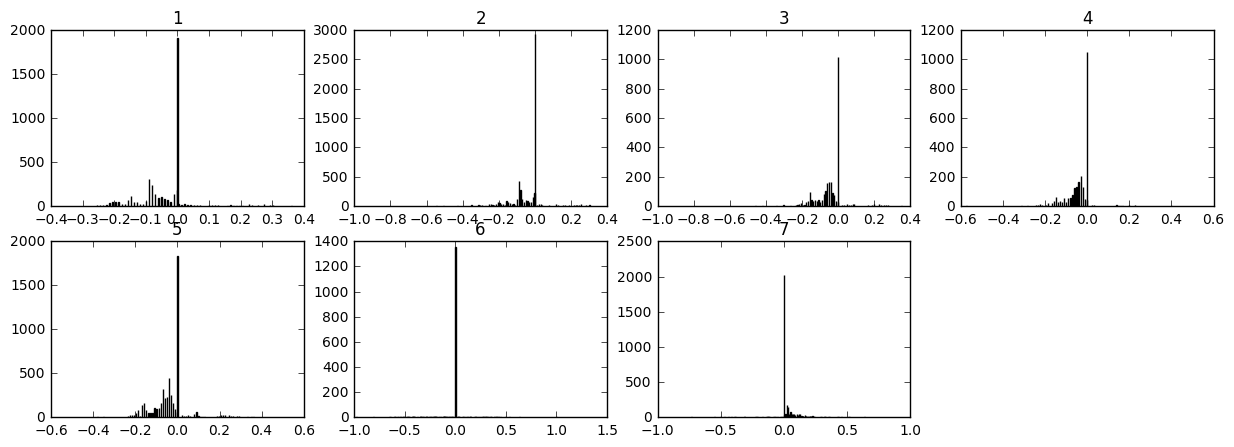

In [6]:
plt.subplots(figsize = (15,5))
plt.subplot(241), plt.bar(Counter(drivingLog1['steering']).keys(),Counter(drivingLog1['steering']).values(),0.001), plt.title("1")
plt.subplot(242), plt.bar(Counter(drivingLog2['steering']).keys(),Counter(drivingLog2['steering']).values(),0.001), plt.title("2")
plt.subplot(243), plt.bar(Counter(drivingLog3['steering']).keys(),Counter(drivingLog3['steering']).values(),0.001), plt.title("3")
plt.subplot(244), plt.bar(Counter(drivingLog4['steering']).keys(),Counter(drivingLog4['steering']).values(),0.001), plt.title("4")
plt.subplot(245), plt.bar(Counter(drivingLog5['steering']).keys(),Counter(drivingLog5['steering']).values(),0.001), plt.title("5")
plt.subplot(246), plt.bar(Counter(drivingLog6['steering']).keys(),Counter(drivingLog6['steering']).values(),0.001), plt.title("6")
plt.subplot(247), plt.bar(Counter(drivingLog7['steering']).keys(),Counter(drivingLog7['steering']).values(),0.001), plt.title("7")

### Count by timeline

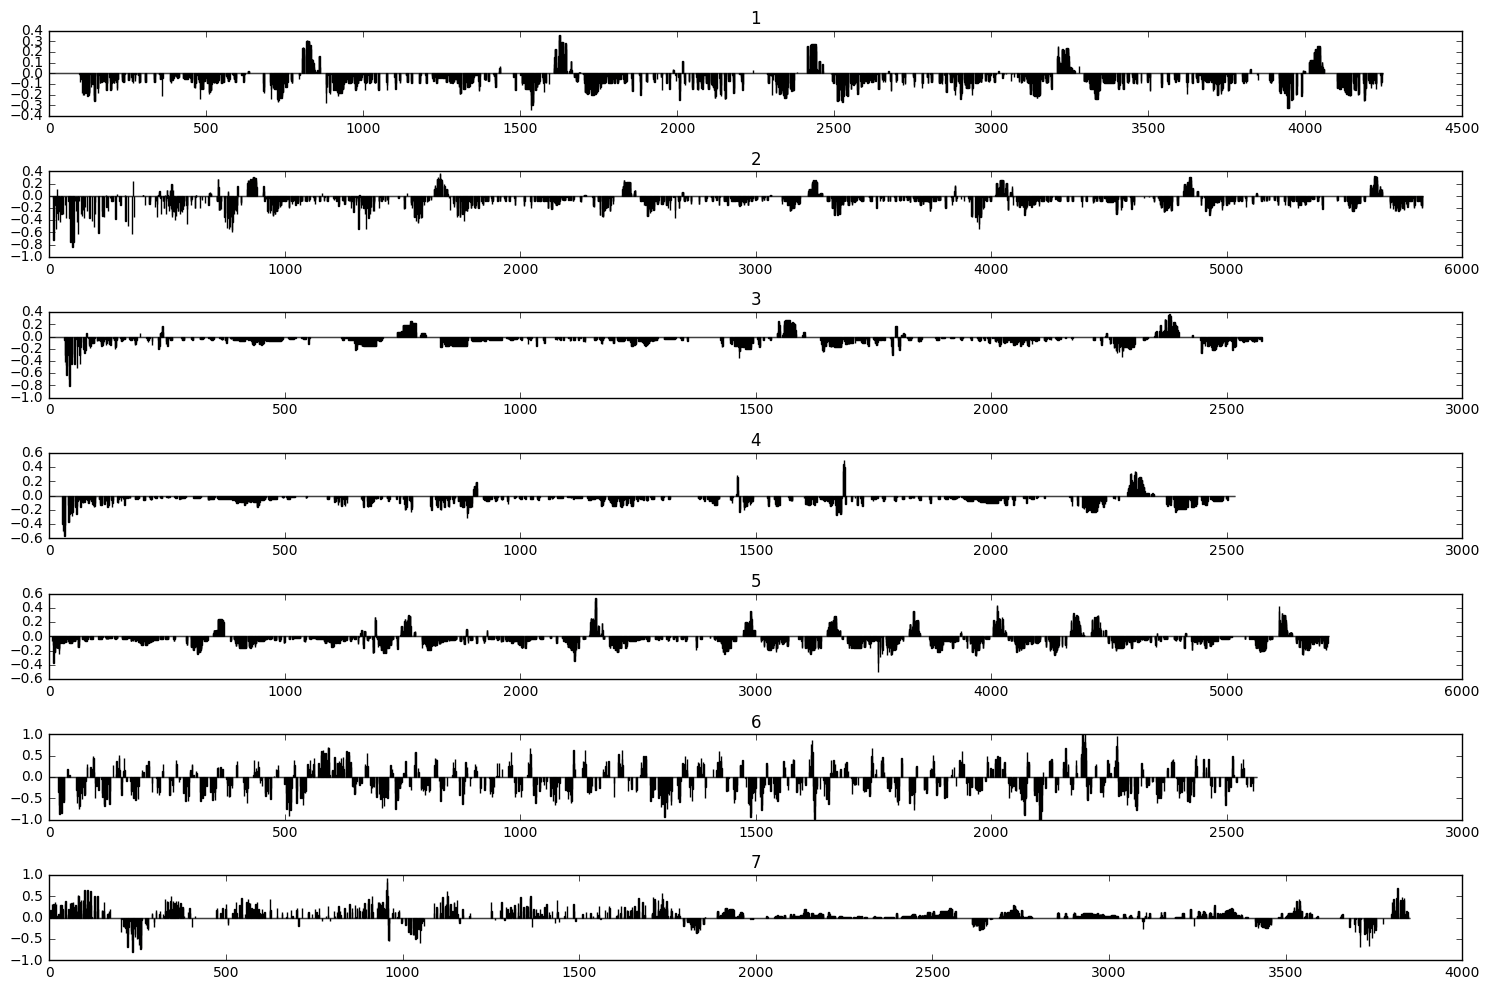

In [7]:
plt.subplots(figsize=(15,10))
plt.subplot(711), plt.bar(np.arange(drivingLog1['steering'].shape[0]), drivingLog1['steering'], 1), plt.title("1")
plt.subplot(712), plt.bar(np.arange(drivingLog2['steering'].shape[0]), drivingLog2['steering'], 1), plt.title("2")
plt.subplot(713), plt.bar(np.arange(drivingLog3['steering'].shape[0]), drivingLog3['steering'], 1), plt.title("3")
plt.subplot(714), plt.bar(np.arange(drivingLog4['steering'].shape[0]), drivingLog4['steering'], 1), plt.title("4")
plt.subplot(715), plt.bar(np.arange(drivingLog5['steering'].shape[0]), drivingLog5['steering'], 1), plt.title("5")
plt.subplot(716), plt.bar(np.arange(drivingLog6['steering'].shape[0]), drivingLog6['steering'], 1), plt.title("6") # recover ver
plt.subplot(717), plt.bar(np.arange(drivingLog7['steering'].shape[0]), drivingLog7['steering'], 1), plt.title("7") # opposite ver
plt.tight_layout()



### Function for Merging each train image data

In [6]:
def load_pick(name):
    with open(name, 'rb') as f:
        save = pickle.load(f)
        trains = save['dataset']
        labels = save['labels']
    return trains, labels


def concat(a,b):
    return np.concatenate((a,b), axis = 0)

## Image data preprocessing 
### 1. Read Images
### 2. Convert to images
### 3. Crop the images
### 4. Resize the images
### 5. reshape

### 1. Read Images

In [8]:
frame = [drivingLog3, drivingLog4, drivingLog5, drivingLog6]
log_table = pd.concat(frame, axis = 0)
log_table = log_table[['center','left','right','steering']]

In [9]:
log_table.reset_index(inplace = True)
print(log_table.shape)

(13089, 5)


In [10]:
log_table1 = log_table.copy()

In [11]:
log_table1['left'][1000]

'/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Keras-P3/Joy2/IMG/left_2017_02_28_22_44_10_465.jpg'

### CENTER, LEFT, RIGHT IMAGE EXTRACT

#### Left, Right steering angle manipulation by adding +0.25 and -0.25

In [12]:
X_train_C, y_train_C = log_table1['center'], log_table1['steering']
X_train_L, y_train_L = log_table1['left'], log_table1['steering'] + 0.25
X_train_R, y_train_R = log_table1['right'], log_table1['steering'] - 0.25

(<matplotlib.axes._subplots.AxesSubplot at 0x129fd6668>,
 <matplotlib.image.AxesImage at 0x12afec358>)

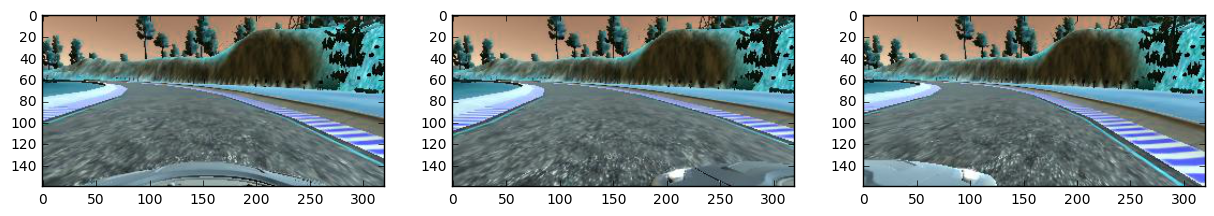

In [15]:
plt.subplots(figsize = (15,5))
img = cv2.imread(X_train_C[0])
plt.subplot(131), plt.imshow(img)
img = cv2.imread(X_train_L[0])
plt.subplot(132), plt.imshow(img)
img = cv2.imread(X_train_R[0])
plt.subplot(133), plt.imshow(img)

(<matplotlib.axes._subplots.AxesSubplot at 0x15665e400>,
 <matplotlib.image.AxesImage at 0x155750208>)

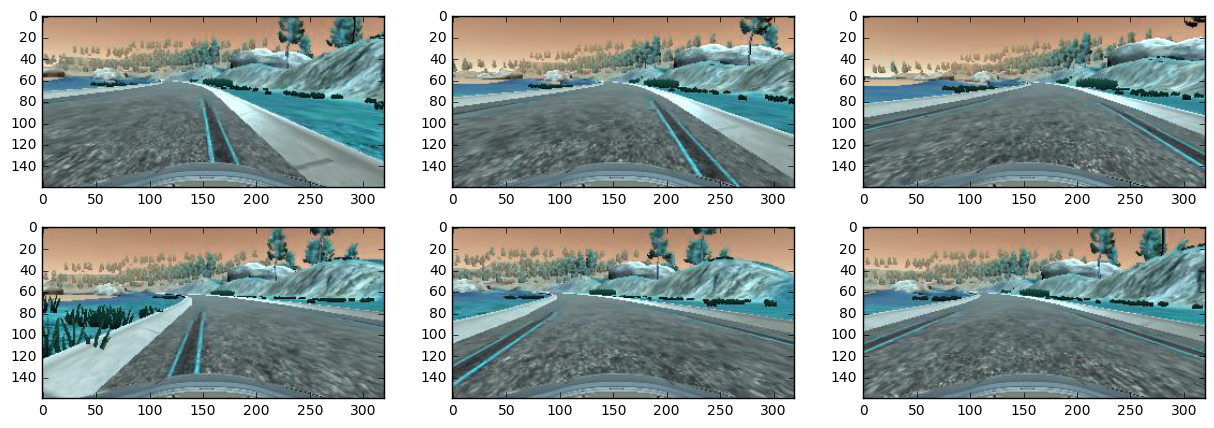

In [36]:
plt.subplots(figsize = (15,5))
img = cv2.imread(drivingLog6['center'][110])
plt.subplot(231), plt.imshow(img)
img = cv2.imread(drivingLog6['center'][125])
plt.subplot(232), plt.imshow(img)
img = cv2.imread(drivingLog6['center'][135])
plt.subplot(233), plt.imshow(img)
img = cv2.imread(drivingLog6['center'][775])
plt.subplot(234), plt.imshow(img)
img = cv2.imread(drivingLog6['center'][785])
plt.subplot(235), plt.imshow(img)
img = cv2.imread(drivingLog6['center'][795])
plt.subplot(236), plt.imshow(img)

(<matplotlib.axes._subplots.AxesSubplot at 0x125eddba8>,
 <Container object of 1301 artists>)

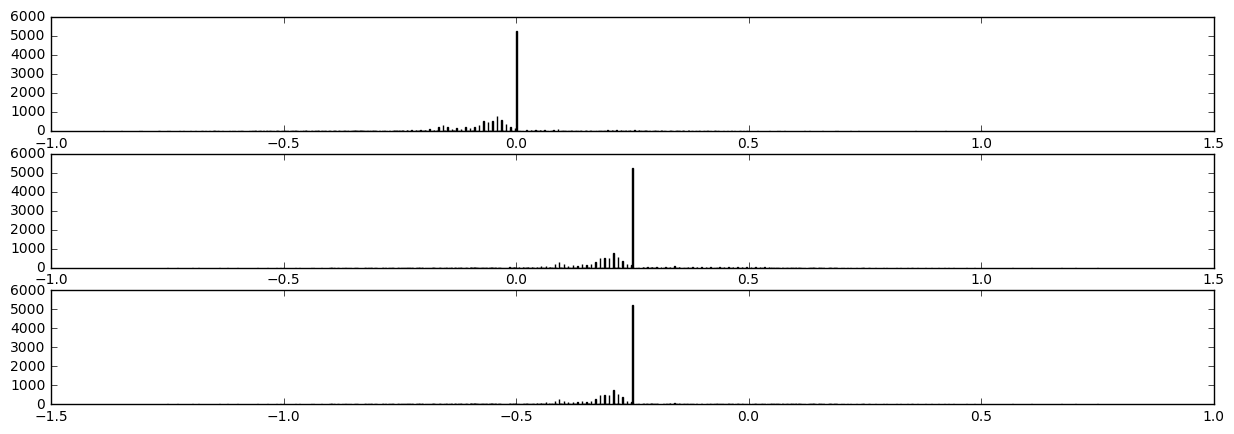

In [37]:
plt.subplots(figsize = (15,5))
plt.subplot(311), plt.bar(Counter(y_train_C).keys(),Counter(y_train_C).values(),0.001)
plt.subplot(312), plt.bar(Counter(y_train_L).keys(),Counter(y_train_L).values(),0.001)
plt.subplot(313), plt.bar(Counter(y_train_R).keys(),Counter(y_train_R).values(),0.001)

In [38]:
def shuffle_val(X_lst, y_lst):

    lst = list(np.arange(y_lst.shape[0]))

    import random
    
    random.shuffle(lst)
        
    rand = lst[:int(len(lst)/5)]
        
    y_label = y_lst[rand]
    X_train = X_lst[rand]

    return X_train, y_label


In [39]:
def image_augmentation(images, labels):
    augmented_img, augmented_mea = [], [] 
    diff_img, diff_mea = [], []
    
    
    for image, measurement in zip(images, labels):
        
#         print(image.shape, measurement.shape)
        if (measurement != 0) and (measurement != 0.25) and (measurement != -0.25):
            augmented_img.append(image)
            augmented_mea.append(measurement)
            img_flip = np.fliplr(image)
            img_flip = np.resize(img_flip, (60,120,3))
            augmented_img.append(img_flip)
            augmented_mea.append(measurement*-1.0)
        else:
            diff_img.append(image)
            diff_mea.append(measurement)
    
    diff_img = np.array(diff_img)
    diff_mea = np.array(diff_mea)
    augmented_img = np.array(augmented_img)
    augmented_mea = np.array(augmented_mea)
            
    train = np.vstack((augmented_img, diff_img))
    label = np.hstack((augmented_mea, diff_mea))
    
    return train, label
#     return augmented_img, augmented_mea

In [40]:
images_C = []
labels_C = []

for line, line2 in zip(X_train_C, y_train_C):
    img = cv2.imread(line)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = imresize(img, (60,120,3))

    images_C.append(img)
    labels_C.append(line2)
    
train_C, label_C = image_augmentation(images_C, labels_C)

(<matplotlib.axes._subplots.AxesSubplot at 0x129a752b0>,
 <matplotlib.text.Text at 0x12a21e550>)

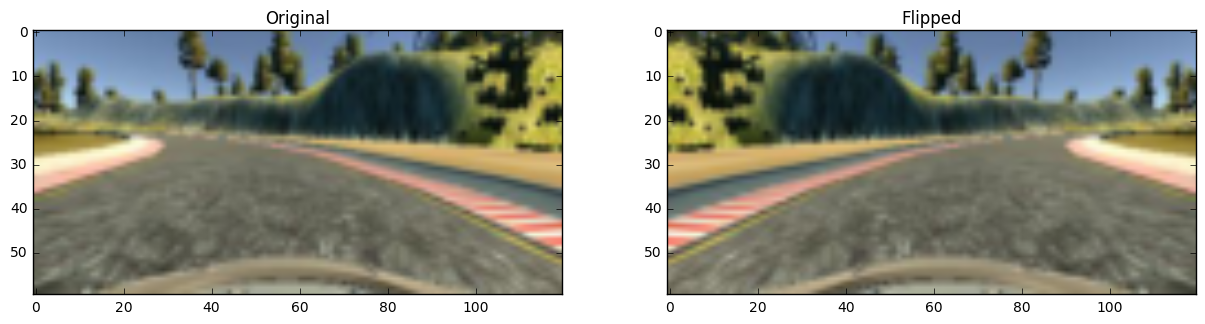

In [46]:
plt.subplots(figsize = (15,5))

plt.subplot(121), plt.imshow(train_C[0]), plt.title('Original')
plt.subplot(122), plt.imshow(train_C[1]), plt.title('Flipped')


In [42]:
images_L = []
labels_L = []

for line, line2 in zip(X_train_L, y_train_L):
    img = cv2.imread(line)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = imresize(img, (60,120,3))

    images_L.append(img)
    labels_L.append(line2)
    
train_L, label_L = image_augmentation(images_L, labels_L)

In [43]:
images_R = []
labels_R = []

for line, line2 in zip(X_train_R, y_train_R):
    img = cv2.imread(line)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = imresize(img, (60,120,3))

    images_R.append(img)
    labels_R.append(line2)
    
train_R, label_R = image_augmentation(images_R, labels_R)

In [51]:
def image_augmentation_up(images, labels, flip):
    
    augmented_img, augmented_mea = [], [] 
    diff_img = []
    diff_mea = []
    
    if flip == False:
        
        for image, measurement in zip(images, labels):

            augmented_img.append(image)
            augmented_mea.append(measurement)

        augmented_img = np.array(augmented_img)
        augmented_mea = np.array(augmented_mea)
        
    if flip == True:
        
        for image, measurement in zip(images, labels):
        
            if (measurement != 0) and (measurement != 0.25) and (measurement != -0.25):
                augmented_img.append(image)
                augmented_mea.append(measurement)
                img_flip = np.fliplr(image)
                augmented_img.append(img_flip)
                augmented_mea.append(measurement*-1.0)

            else:
                diff_img.append(image)
                diff_mea.append(measurement)
        
        diff_img = np.array(diff_img)
        diff_mea = np.array(diff_mea)
        
        augmented_img = np.array(augmented_img)
        augmented_mea = np.array(augmented_mea)
        
        print(augmented_mea.shape, diff_mea.shape)
        
        if diff_mea.shape[0] ==0:
            augmented_img = augmented_img
            augmented_mea = augmented_mea
        else:
            augmented_img = np.vstack((augmented_img, diff_img))
            augmented_mea = np.hstack((augmented_mea, diff_mea))
        
    return augmented_img, augmented_mea


def update_df(new, ver = False):
#     log_table1 = pd.read_csv(new)
    log_table1 = new
    X_train_C, y_train_C = log_table1['center'], log_table1['steering']
    X_train_L, y_train_L = log_table1['left'], log_table1['steering'] + 0.25
    X_train_R, y_train_R = log_table1['right'], log_table1['steering'] - 0.25

    images_C, images_L, images_R = [], [], []
    labels_C, labels_L, labels_R = [], [], []

    for line, line2 in zip(X_train_C, y_train_C):
        img = cv2.imread(line)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = imresize(img, (60,120,3))

#         img = np.resize(img, (60,120,1))

        images_C.append(img)
        labels_C.append(line2)

    train_C, label_C = image_augmentation_up(images_C, labels_C, ver)
    
#     print(train_C.shape, label_C.shape)


    for line, line2 in zip(X_train_L, y_train_L):
        img = cv2.imread(line)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = imresize(img, (60,120,3))

#         img = np.resize(img, (60,120,1))

        images_L.append(img)
        labels_L.append(line2)
        
    train_L, label_L = image_augmentation_up(images_L, labels_L, ver)

#     print(train_L.shape, label_L.shape)

    for line, line2 in zip(X_train_R, y_train_R):
        img = cv2.imread(line)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = imresize(img, (60,120,3))


#         img = np.resize(img, (60,120,1))

        images_R.append(img)
        labels_R.append(line2)

    train_R, label_R = image_augmentation_up(images_R, labels_R, ver)
    
    train_M = np.concatenate((train_C, train_L, train_R), axis = 0)
    label_M = np.concatenate((label_C, label_L, label_R), axis = 0)

    return train_M, label_M

    

# Image augmentation - Merge Left, Right, Center Image

In [48]:
train_M = np.concatenate((train_C, train_L, train_R), axis = 0)
label_M = np.concatenate((label_C, label_L, label_R), axis = 0)

print(train_M.shape, label_M.shape)

(62787, 60, 120, 3) (62787,)


In [49]:
def del_DF(train_M, label_M, val):
    p_p = []
    p_z = []
    p_m = []

    print(train_M.shape, label_M.shape)
    
    for idx, vals in enumerate(label_M):
        if vals == 0.25:
            p_p.append(idx)
        elif vals == 0.0:
            p_z.append(idx)
        elif vals == -0.25:
            p_m.append(idx)


    print(len(p_p), len(p_z), len(p_m))

    import random
    random.shuffle(p_p)
    random.shuffle(p_z)
    random.shuffle(p_m)


    idx_list = \
        p_p[:len(p_p)-val] \
        + p_z[:len(p_z)-val] \
        + p_m[:len(p_m)-val]

    label_M = np.delete(label_M, idx_list, 0)
    train_M = np.delete(train_M, idx_list, 0)

    print(train_M.shape, label_M.shape)
    
    return train_M, label_M

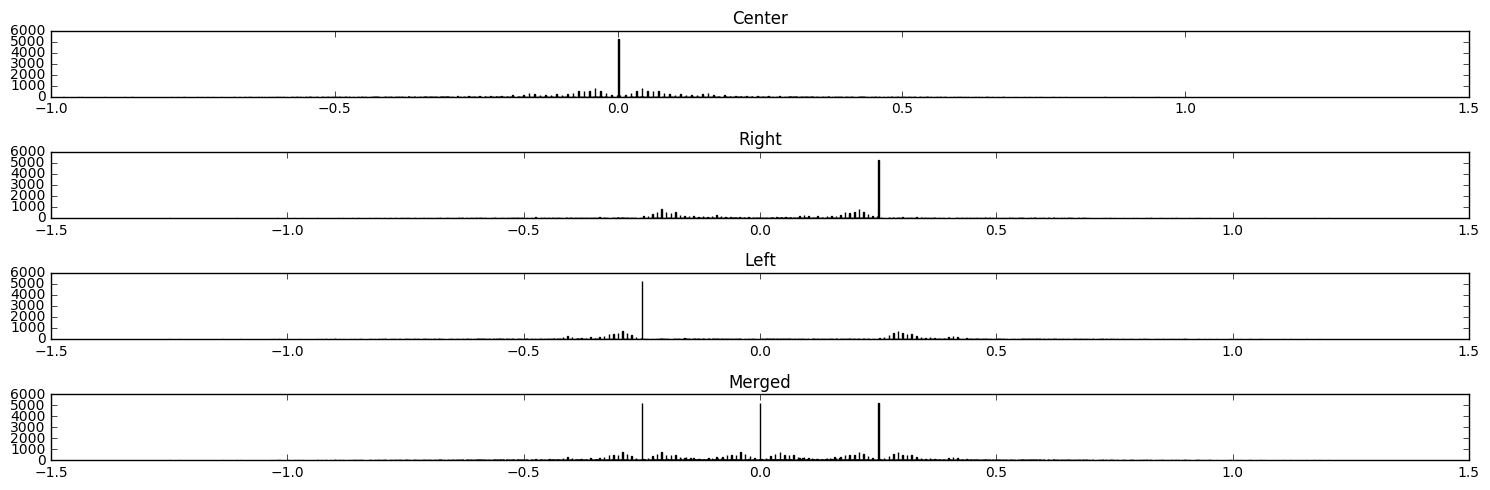

In [50]:
plt.subplots(figsize = (15,5))
plt.subplot(411), plt.bar(Counter(label_C).keys(),Counter(label_C).values(),0.001), plt.title("Center")
plt.subplot(412), plt.bar(Counter(label_L).keys(),Counter(label_L).values(),0.001), plt.title("Right")
plt.subplot(413), plt.bar(Counter(label_R).keys(),Counter(label_R).values(),0.001), plt.title("Left")
plt.subplot(414), plt.bar(Counter(label_M).keys(),Counter(label_M).values(),0.001), plt.title("Merged")
plt.tight_layout()

### Model architecture

### Image normalization - faster
### Cropping Image - faster, effective
### Maxpooling - prevent overfitting
### Dense
### Dropout - prevent overfitting
### Adam optimizer

# Dataset update needed - before split train and test

In [52]:
if True:
    new = drivingLog6[1000:2000]
    train_up, label_up = update_df(new, True)
    
    train_M = np.vstack((train_M, train_up))
    label_M = np.hstack((label_M, label_up))

print(train_M.shape, label_M.shape)

(938,) (531,)
(938,) (531,)
(938,) (531,)
(67194, 60, 120, 3) (67194,)


In [238]:
# train_M, label_M = del_DF(train_M, label_M, 500)

In [54]:
def remove_lst(train_M,label_M,lmt):
    i = 0
    lst = []
    idx_list = []
    idy_list = []
    
    import random
#     from iteration_utilities import flatten

    for val in Counter(label_M).values():
        if val>lmt:
            lst.append(list(Counter(label_M).keys())[i])
        
        i += 1
    
    for ix in lst:    
        p_lst = []
        for idx, vals in enumerate(label_M):
            if vals == ix:
                p_lst.append(idx)
            
        random.shuffle(p_lst)        
        idx_list.append(p_lst[:(len(p_lst)-lmt)])
    
    for a in np.arange(len(idx_list)):
        for b in idx_list[a]:
            idy_list.append(b)

#     print(idy_list)
    
    label_Mr = np.delete(label_M, idy_list, 0)
    train_Mr = np.delete(train_M, idy_list, 0)
    
    print(train_Mr.shape, label_Mr.shape)
    return train_Mr, label_Mr

### Image merging - Added more cornering images for better result

In [55]:
frame = [drivingLog1[drivingLog1['steering'] > 0.2]]         

if True:

    new = pd.concat(frame, axis = 0)

    train_up, label_up = update_df(new, True)
    
    train_Mr = np.vstack((train_M, train_up))
    label_Mr = np.hstack((label_M, label_up))

print(train_Mr.shape, label_Mr.shape)

(198,) (0,)
(198,) (0,)
(198,) (0,)
(67788, 60, 120, 3) (67788,)


(<Container object of 7725 artists>, <matplotlib.text.Text at 0x12cb524a8>)

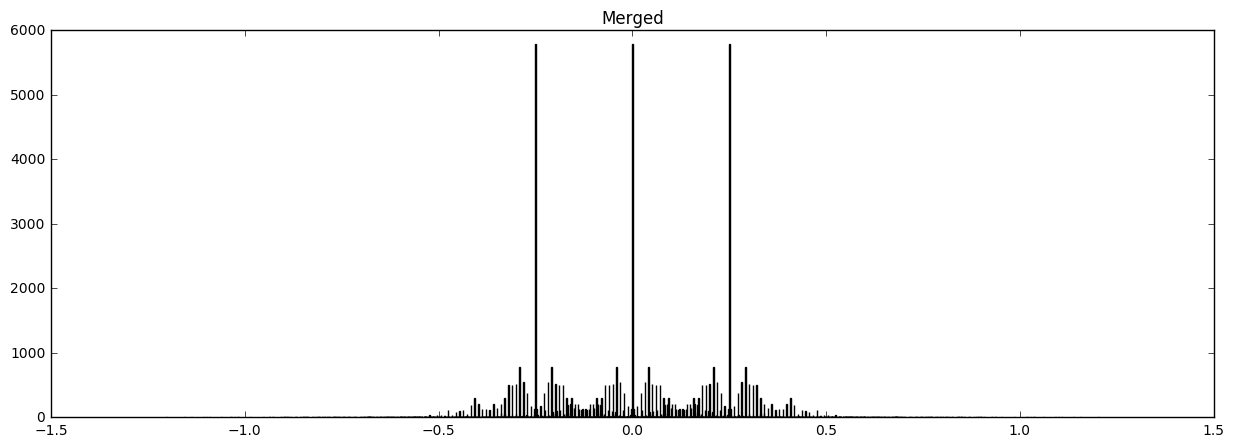

In [56]:
plt.subplots(figsize = (15,5))
plt.bar(Counter(label_Mr).keys(),Counter(label_Mr).values(),0.001), plt.title("Merged")

### Too many dataset, which could make the processing slow. 
### If specific steering angle exists too many, shuffle the image data for the angle and throw away some of them

In [57]:
print(train_Mr.shape, label_Mr.shape)

train_Mr, label_Mr = remove_lst(train_Mr, label_Mr,180)


(67788, 60, 120, 3) (67788,)
(36306, 60, 120, 3) (36306,)


(<Container object of 7725 artists>, <matplotlib.text.Text at 0x135481048>)

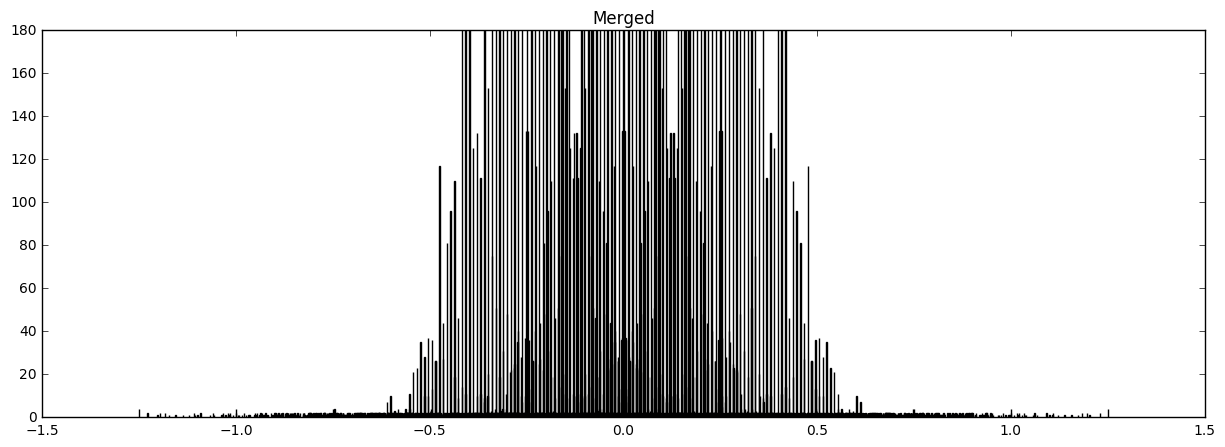

In [58]:
plt.subplots(figsize = (15,5))
plt.bar(Counter(label_Mr).keys(),Counter(label_Mr).values(),0.001), plt.title("Merged")

In [59]:
X_train, X_test, y_train, y_test = train_test_split(train_Mr, label_Mr, test_size=0.3, random_state=42)

In [60]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25414, 60, 120, 3) (10892, 60, 120, 3) (25414,) (10892,)


# Model Architecture

In [61]:
adam = Adam(lr = 0.001)

model = Sequential()

model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (60,120,3)))
model.add(Cropping2D(cropping=((20,10),(0,0))))

model.add(Conv2D(5,3,3, border_mode = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(5,5,5, border_mode = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(24,5,5, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(36,5,5, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,3,3, border_mode='same',  activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Dense(1))

stop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 5)

model.compile(loss = 'mse', optimizer = adam)

history = model.fit(X_train, y_train, batch_size = 64, 
                    validation_data = (X_test, y_test), nb_epoch = 100, callbacks = [stop])



Train on 25414 samples, validate on 10892 samples
Epoch 1/100
25414/25414 [==============================] - 73s - loss: 0.0627 - val_loss: 0.0691
Epoch 2/100
25414/25414 [==============================] - 65s - loss: 0.0519 - val_loss: 0.0655
Epoch 3/100
25414/25414 [==============================] - 66s - loss: 0.0502 - val_loss: 0.0582
Epoch 4/100
25414/25414 [==============================] - 64s - loss: 0.0491 - val_loss: 0.0530
Epoch 5/100
25414/25414 [==============================] - 68s - loss: 0.0479 - val_loss: 0.0606
Epoch 6/100
25414/25414 [==============================] - 65s - loss: 0.0475 - val_loss: 0.0483
Epoch 7/100
25414/25414 [==============================] - 63s - loss: 0.0465 - val_loss: 0.0434
Epoch 8/100
25414/25414 [==============================] - 65s - loss: 0.0468 - val_loss: 0.0474
Epoch 9/100
25414/25414 [==============================] - 62s - loss: 0.0459 - val_loss: 0.0450
Epoch 10/100
25414/25414 [==============================] - 65s - loss: 0.045

### Review test result

In [62]:
i = 0
for a in X_test[:10]:
    print(y_test[i], model.predict(a[None,:,:,:])[0][0])
    i += 1

0.08980883 0.162372
0.17955703 0.0297503
-0.247337218 -0.087627
0.08980875 -0.0190359
-0.1188574 -0.111882
-0.1091745 -0.154288
0.928318 0.245955
0.26234567 0.0506246
0.00239 0.162096
0.02202855 0.0928705


dict_keys(['val_loss', 'loss'])


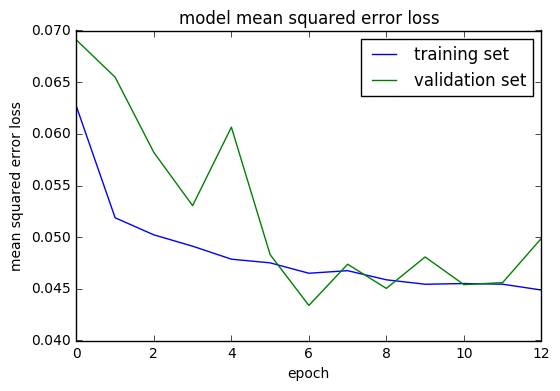

In [63]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Save model

In [64]:
json_string = model.to_json()

with open('model.json', 'w') as f:
    json.dump(json_string, f)
print("Saved model.json for a model configure")

model.save_weights('model.h5')
print("Saved model.h5 for a model weights")

Saved model.json for a model configure
Saved model.h5 for a model weights


In [65]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: No module named 'pydot'